In [1]:
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
import torch

In [2]:
from method_1 import SearchAvailablePosition
from method_2 import SearchAction
from method_3 import ChangeBoard

from Othello import Othello

In [3]:
othello = Othello()

black = 1
white = 2

In [4]:
class randomAgent:
    def take_action(self, board, changeable_Pos, Position_Row, Position_Col, Change_Position):
        if len(Change_Position)==0:
            setrow, setcol = 0,0
        else:
            idx = np.random.randint(len(Position_Row))
            setrow, setcol = Position_Row[idx], Position_Col[idx]
        return setrow, setcol
    
class greedyAgent:
    def take_action(self, board, changeable_Pos, Position_Row, Position_Col, Change_Position):
        if len(Change_Position)==0:
            setrow, setcol = 0,0
        else:
            Change_Position_len = [len(l[0]) for l in Change_Position]
            idx_l = [i for i, l in enumerate(Change_Position_len) if l==max(Change_Position_len)]
            idx = np.random.choice(idx_l)
            setrow, setcol = Position_Row[idx], Position_Col[idx]
        return setrow, setcol

In [5]:
agent_1 = randomAgent()
agent_2 = greedyAgent()

In [6]:
w_1=0
w_2=0
draw=0

win_1_rate = []
win_2_rate = []
draw_rate = []

In [59]:
for _ in tqdm(range(2000)):
    board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
    while not done:
        if othello.color==1:
            setrow, setcol = agent_1.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        else:
            setrow, setcol = agent_2.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        if done:
            if len(board[board==1])>len(board[board==2]):
                w_1+=1
            elif len(board[board==1])<len(board[board==2]):
                w_2+=1
            else:
                draw+=1
            
            win_1_rate.append(w_1/(w_1+w_2+draw))
            win_2_rate.append(w_2/(w_1+w_2+draw))            
            draw_rate.append(draw/(w_1+w_2+draw))            

In [60]:
w_1, w_2, draw

(770, 1155, 75)

In [61]:
w_1+w_2+draw

2000

In [64]:
win_1_rate[-1],win_2_rate[-1],draw_rate[-1]

(0.385, 0.5775, 0.0375)

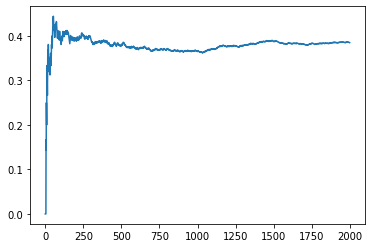

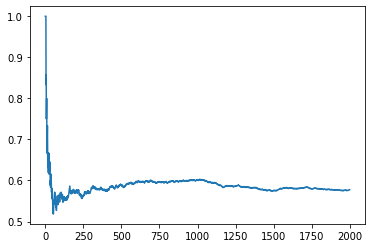

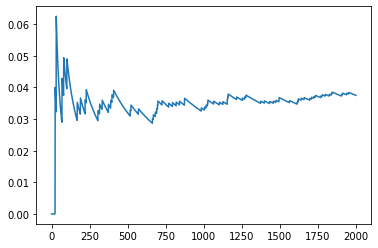

In [63]:
for l in [win_1_rate, win_2_rate, draw_rate]:
    plt.plot(l)
    plt.show()

In [104]:


a = torch.rand(10,6, 8,8)
out = model(a)
print(out.size())

torch.Size([10, 12, 7, 7])


In [110]:
encoder_layer = nn.TransformerEncoderLayer(d_model=3, nhead=3)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=8)
# Attentionの関数は、（系列長, バッチサイズ, 次元数）の形で受け取る
# （バッチサイズ, 系列長, 次元数）=>（系列長, バッチサイズ, 次元数）
#enc = enc.permute(1, 0, 2) 

a = torch.rand(10,3,8,8)
a = a.reshape(10,3,64)
a = a.permute(2,0,1)#（バッチサイズ, 次元数,系列長）=>（系列長, バッチサイズ, 次元数）
print(a.size())
out = transformer_encoder(a)
out.size()

torch.Size([64, 10, 3])


torch.Size([64, 10, 3])

In [111]:
out_1 = out.permute(1,2,0).reshape(10,3,8,8)

In [146]:
a = torch.rand(10,3, 8,8)
out = torch.cat((out_1,a), dim=1)

In [147]:
out.size()

torch.Size([10, 6, 8, 8])

In [148]:
out_2 =nn.AdaptiveAvgPool2d((1,1))(out)

In [149]:
torch.flatten(out_2,1).size()

torch.Size([10, 6])

In [353]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        
        self.input_dim = input_dim

        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, input_dim*8, 3),
            nn.Dropout2d(0.3),
            nn.ReLU(),

            nn.Conv2d(input_dim*8, input_dim*8, 3),
            nn.Dropout2d(0.3),
            nn.ReLU(),
            
            nn.Conv2d(input_dim*8, input_dim*16, 3),
        )
        
        self.transformer_encoder_1 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim*16, nhead=input_dim),
            num_layers=3
        )
        
        self.fc_1 = nn.Sequential(
            nn.Linear(4,2),
            nn.Dropout(),
            nn.ReLU(),
        )
        
        self.fc_p = nn.Sequential(
            nn.Linear(96,64),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64,64)
        )
        
        self.fc_v = nn.Sequential(
            nn.Linear(96,64),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64,1)
        )
    
    def attention_forward(self, x, layer):
        
        N =  x.size(0)
        inp_dim = x.size(1)
        h_dim = x.size(2)
        w_dim = x.size(3)
        att_inp = torch.flatten(x,2).permute(2,0,1)#（バッチサイズ, 次元数, W, H）=>（バッチサイズ, 次元数,系列長）=>（系列長, バッチサイズ, 次元数）
        att_inp = layer(att_inp)
        att_inp = att_inp.permute(1,2,0)
        
        att_inp = att_inp.reshape(N, inp_dim, h_dim, w_dim)
        return att_inp
    
    def forward(self, x):
        x = self.conv(x)
        x = self.attention_forward(x, self.transformer_encoder_1)
        x = torch.flatten(x, 2)
        x = self.fc_1(x)
        x = torch.flatten(x,1)
        p = self.fc_p(x)
        v = self.fc_v(x)
        return {'policy':p, 'value':v}

In [354]:
48*2

96

In [355]:
model = Model(3)

In [356]:
batch_size=128

In [7]:
def getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position):
    state = np.zeros((3,8,8))
    for i in range(1,3):
        state[i-1,board==i]=1
    for i, (r, c) in enumerate(zip(Position_Row,Position_Col)):
        n = len(Change_Position[i][0])
        state[2,r,c]=n
    return state.tolist()

def getReward(board):
    reward_1 = len(board[board==1])
    reward_2 = len(board[board==2])
    return reward_1, reward_2

In [12]:
states = []
first_states = []
first_rewards = []
first_actions = []

second_states = []
second_rewards = []
second_actions = []

board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
state = getState(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
states.append(state)
print("states",len(states))
print("color",othello.color)
print("board",len(board[board==0]))

while not done:
    if othello.color==1:
        state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        first_states.append(state)
        
        setrow, setcol = agent_1.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        
        first_actions.append(8*setrow+setcol )
        reward_1, _ = getReward(board)
        first_rewards.append(reward_1)
        
    else:
        state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        second_states.append(state)
        
        setrow, setcol = agent_2.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        
        second_actions.append(8*setrow+setcol )
        _, reward_2 = getReward(board)
        second_rewards.append(reward_2)
        
    state = getState(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
    states.append(state)
    print("states",len(states))
    print("color",othello.color)
    print("board",len(board[board==0]))
    
    #print(len(states))
    
if othello.color==1:
    state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
    first_states.append(state)
    
    reward_1, _ = getReward(board)
    first_rewards.append(reward_1)
    
if othello.color==2:
    state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
    second_states.append(state)
    _, reward_2 = getReward(board)
    second_rewards.append(reward_2)

    
    
states = torch.FloatTensor(states)
first_states = torch.FloatTensor(first_states)
second_states = torch.FloatTensor(second_states)

print(f"states.size  {states.size()}")
print(f"first_states.size  {first_states.size()}")
print(f"second_states.size  {second_states.size()}")

states 1
color 1
board 60
states 2
color 2
board 59
states 3
color 1
board 58
states 4
color 2
board 57
states 5
color 1
board 56
states 6
color 2
board 55
states 7
color 1
board 54
states 8
color 2
board 53
states 9
color 1
board 52
states 10
color 2
board 51
states 11
color 1
board 50
states 12
color 2
board 49
states 13
color 1
board 48
states 14
color 2
board 47
states 15
color 1
board 46
states 16
color 2
board 45
states 17
color 1
board 44
states 18
color 2
board 43
states 19
color 1
board 42
states 20
color 2
board 41
states 21
color 1
board 40
states 22
color 2
board 39
states 23
color 1
board 38
states 24
color 2
board 37
states 25
color 1
board 36
states 26
color 2
board 35
states 27
color 1
board 34
states 28
color 2
board 33
states 29
color 1
board 32
states 30
color 2
board 31
states 31
color 1
board 30
states 32
color 2
board 29
states 33
color 1
board 28
states 34
color 2
board 27
states 35
color 1
board 26
states 36
color 2
board 25
states 37
color 1
board 24
states 38


In [13]:
first_states[-1]

tensor([[[0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 0., 1., 1., 1.],
         [0., 1., 0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 1., 1., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 1., 0., 0., 0.],
         [1., 0., 1., 1., 0., 1., 1., 0.],
         [1., 1., 1., 0., 0., 1., 1., 0.],
         [1., 1., 1., 0., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
       

In [10]:
len(first_rewards), len(second_rewards)

(31, 30)

In [523]:
done, othello.color, othello.num_step

(True, 1, 61)

In [524]:
states[-1]

tensor([[[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 1., 1., 1., 0.],
         [0., 0., 0., 1., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 1., 1., 1.],
         [1., 1., 0., 1., 0., 0., 0., 1.],
         [1., 1., 1., 0., 1., 0., 0., 1.],
         [0., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
       

In [525]:
board

array([[1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 2, 2, 2, 2, 2],
       [1, 2, 1, 2, 2, 2, 2, 2],
       [1, 2, 2, 1, 2, 2, 2, 2],
       [1, 2, 2, 2, 1, 2, 2, 2],
       [1, 2, 1, 2, 1, 1, 1, 2],
       [1, 1, 2, 1, 2, 1, 1, 2],
       [1, 2, 2, 2, 2, 2, 2, 2]])

In [7]:
states = []
first_states = []
second_states = []
first_rewards = []
second_rewards = []

board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
first_states.append(state)

for _ in range(4):
    state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
    states.append(state)
    
    if othello.color==1:
        setrow, setcol = agent_1.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        
        state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        _, reward_2 = getReward(board)
        second_states.append(state)
        second_rewards.append(reward_2)
        
    else:
        setrow, setcol = agent_2.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        
        state = getState( board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        reward_1, _ = getReward(board)
        first_states.append(state)
        first_rewards.append(reward_1)

NameError: name 'getState' is not defined

In [648]:
for a in [board, changeable_Pos, Position_Row, Position_Col, Change_Position, done]:
    print(a)
    print("#############")

[[0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0]
 [0 0 1 2 1 0 0 0]
 [0 0 0 2 1 0 0 0]
 [0 0 0 2 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
#############
[[0 0 1 0 1 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
#############
[0, 0, 1, 3, 4, 5]
#############
[2, 4, 2, 2, 2, 2]
#############
[([1], [3]), ([1], [3]), ([2], [3]), ([3], [3]), ([4, 3], [3, 3]), ([4], [3])]
#############
False
#############


<function bool.__new__(*args, **kwargs)>

In [481]:
othello.color

1

In [482]:
first_states

[[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
   [0.0,

In [448]:
len(first_states), len(second_states)

(31, 30)

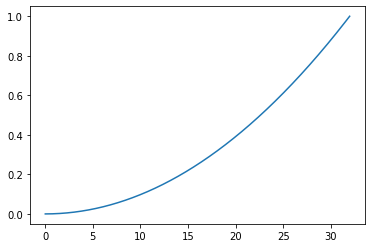

In [431]:
x = np.arange(0,32,0.01)
y = (x)**2/(x.max())**2
plt.plot(x, y)
plt.show()

In [432]:
out_x = model(states)

In [433]:
states[:,2,:,:].flatten(1).size()

torch.Size([64, 64])

In [434]:
out_x['policy'].size(), out_x['value'].size()

(torch.Size([64, 64]), torch.Size([64, 1]))

In [435]:
nn.LogSoftmax(dim=1)(out_x['policy'])

tensor([[-4.3481, -4.1534, -4.1216,  ..., -4.0416, -4.1657, -4.1113],
        [-4.1795, -4.2820, -4.1972,  ..., -4.2211, -4.1621, -4.2128],
        [-4.1592, -4.1413, -4.3553,  ..., -4.1634, -4.1266, -4.3641],
        ...,
        [-4.1358, -4.2277, -4.0391,  ..., -4.2160, -4.4866, -4.1762],
        [-4.4209, -4.2966, -3.9432,  ..., -4.1439, -4.0769, -4.4596],
        [-4.3512, -3.8568, -4.1811,  ..., -3.9635, -4.1111, -4.4967]],
       grad_fn=<LogSoftmaxBackward>)

In [436]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [437]:
len(board[board==1]), len(board[board==2])

(36, 28)

In [438]:
loss_l = []

In [251]:
for _ in tqdm(range(100)):
    model = model.eval()
    x = torch.rand(128, 3, 8, 8)
    y = model(x)
    loss = -y['value'].mean()
    optim.zero_grad()
    loss.backward()
    loss_l.append(loss.item())
    optim.step()

torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])


KeyboardInterrupt: 

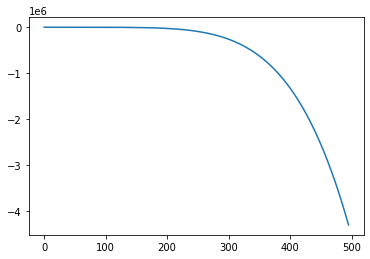

In [178]:
plt.plot(loss_l)